In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

In [2]:
path = "C:\\Users\\aiswa\\OneDrive\\Desktop\\Jupyter\\Framingham Heart Study\\framingham_heart_study.csv"

In [3]:
df= pd.read_csv(path)

In [4]:
# Basic Info
print("Shape:", df.shape)
print(df.dtypes)
display(df.head())

Shape: (4240, 16)
male                 int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


For this dataset, let's take the target variable TenYearCHD (1 = heart disease within 10 years, 0 = no).

In [5]:
# Check missing values
missing_counts = df.isnull().sum()
print("Missing values:\n", missing_counts[missing_counts > 0])

Missing values:
 education     105
cigsPerDay     29
BPMeds         53
totChol        50
BMI            19
heartRate       1
glucose       388
dtype: int64


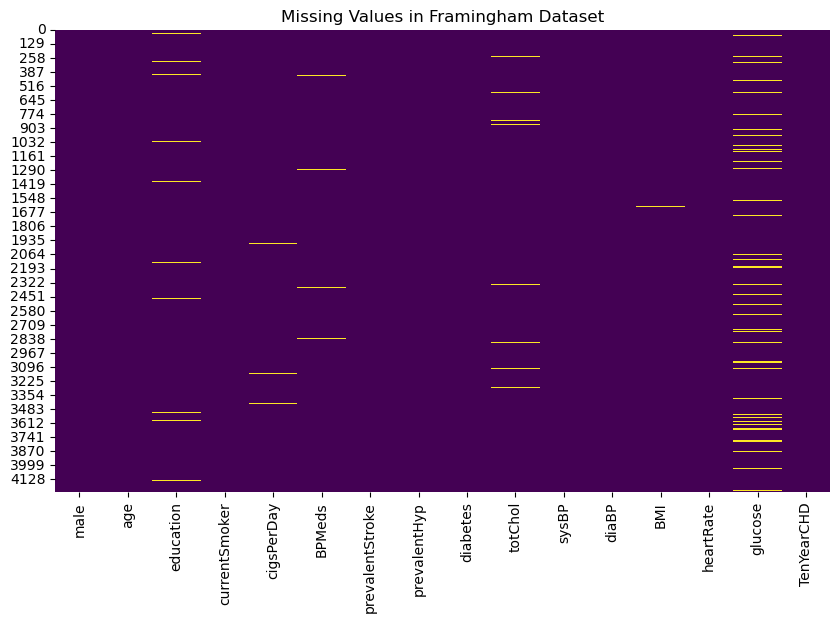

In [6]:
# Visualize missingness
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Framingham Dataset")
plt.show()

In [8]:
# Drop rows with missing target if any
df = df.dropna(subset=["TenYearCHD"])

#Separate Features and Target
X = df.drop(columns=["TenYearCHD"])
y = df["TenYearCHD"]

In [9]:
#Identify Numeric Columns Only (for imputers)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_numeric = X[numeric_cols]

## Imputation Methods

In [10]:
#Apply Different Imputation Techniques

#Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
X_mean_imputed = pd.DataFrame(mean_imputer.fit_transform(X_numeric), columns=numeric_cols)

In [11]:
#Median Imputation
median_imputer = SimpleImputer(strategy='median')
X_median_imputed = pd.DataFrame(median_imputer.fit_transform(X_numeric), columns=numeric_cols)

In [12]:
#KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
X_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(X_numeric), columns=numeric_cols)

In [13]:
#Iterative Imputer (like MICE)
iter_imputer = IterativeImputer(random_state=0)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X_numeric), columns=numeric_cols)

In [14]:
#Adding Back Target and Saving for Modeling
df_mean = pd.concat([X_mean_imputed, y.reset_index(drop=True)], axis=1)
df_median = pd.concat([X_median_imputed, y.reset_index(drop=True)], axis=1)
df_knn = pd.concat([X_knn_imputed, y.reset_index(drop=True)], axis=1)
df_iter = pd.concat([X_iter_imputed, y.reset_index(drop=True)], axis=1)

# Save versions
df_mean.to_csv("framingham_mean_imputed.csv", index=False)
df_median.to_csv("framingham_median_imputed.csv", index=False)
df_knn.to_csv("framingham_knn_imputed.csv", index=False)
df_iter.to_csv("framingham_iter_imputed.csv", index=False)

## Model Training and Evaluation

In [69]:
#creating an empty list
results = [] 

#Creating a Reusable Model Function
def evaluate_models(df, method_name):
    X = df.drop(columns=["TenYearCHD"])
    y = df["TenYearCHD"]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Logistic Regression
    log_model = LogisticRegression(max_iter=5000)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)
    y_prob_log = log_model.predict_proba(X_test)[:, 1]

    # Random Forest
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

    # --- Storing metrics for summary table ---
    results.append({
        'Imputation Method': method_name,
        'Model': 'Logistic Regression',
        'Accuracy': accuracy_score(y_test, y_pred_log),
        'ROC AUC': roc_auc_score(y_test, y_prob_log)
    })
    results.append({
        'Imputation Method': method_name,
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'ROC AUC': roc_auc_score(y_test, y_prob_rf)
    })
    
    # Metrics
    print(f"\n {method_name} — Logistic Regression")
    print("Accuracy:", accuracy_score(y_test, y_pred_log))
    print("ROC AUC:", roc_auc_score(y_test, y_prob_log))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
    print(classification_report(y_test, y_pred_log))

    print(f"\n {method_name} — Random Forest")
    print("Accuracy:", accuracy_score(y_test, y_pred_rf))
    print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))

    # ROC Plot
    RocCurveDisplay.from_predictions(y_test, y_prob_log, name=f"{method_name} - Logistic", color="blue")
    RocCurveDisplay.from_predictions(y_test, y_prob_rf, name=f"{method_name} - RF", color="green")


 Mean Imputation — Logistic Regression
Accuracy: 0.845125786163522
ROC AUC: 0.7018876622472353
Confusion Matrix:
 [[1065   14]
 [ 183   10]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1079
           1       0.42      0.05      0.09       193

    accuracy                           0.85      1272
   macro avg       0.64      0.52      0.50      1272
weighted avg       0.79      0.85      0.79      1272


 Mean Imputation — Random Forest
Accuracy: 0.845125786163522
ROC AUC: 0.6686218769057898
Confusion Matrix:
 [[1065   14]
 [ 183   10]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1079
           1       0.42      0.05      0.09       193

    accuracy                           0.85      1272
   macro avg       0.64      0.52      0.50      1272
weighted avg       0.79      0.85      0.79      1272


 Median Imputation — Logistic Regression
Accuracy: 0.84512578616352

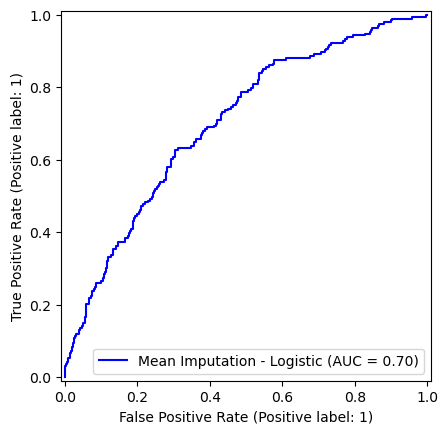

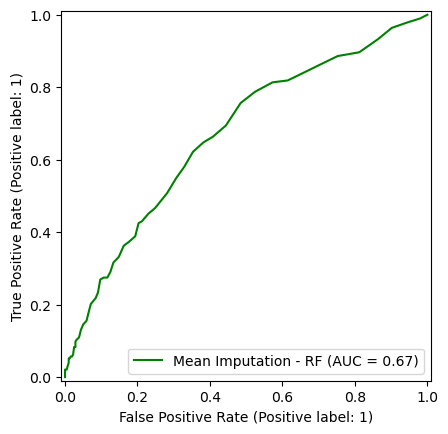

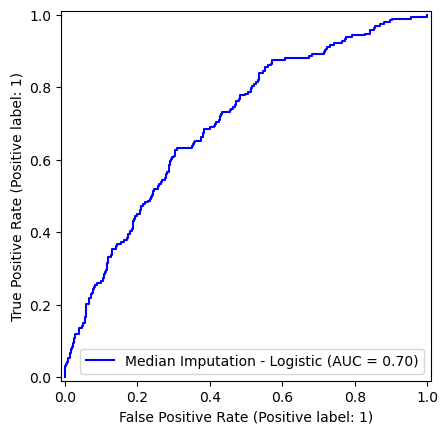

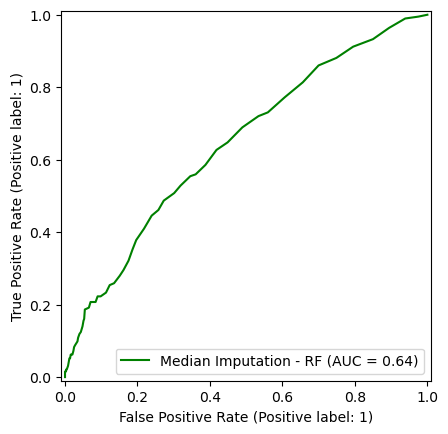

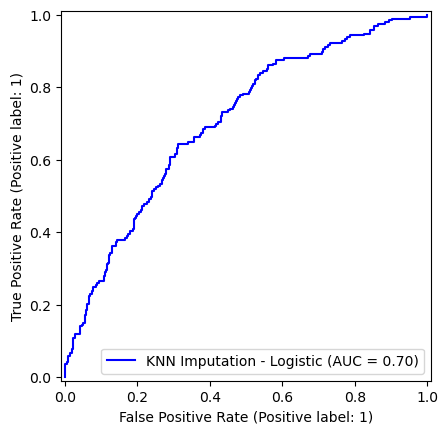

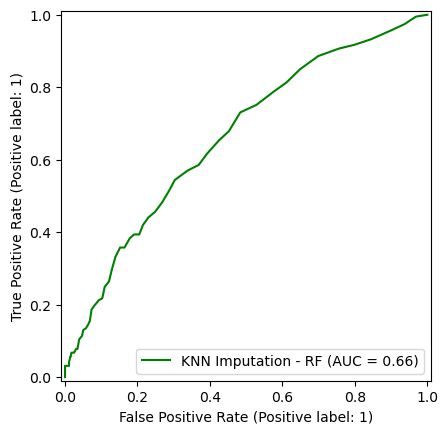

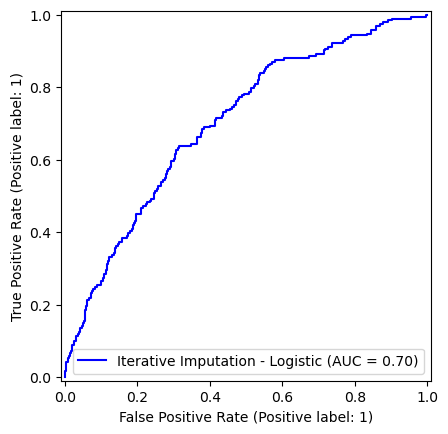

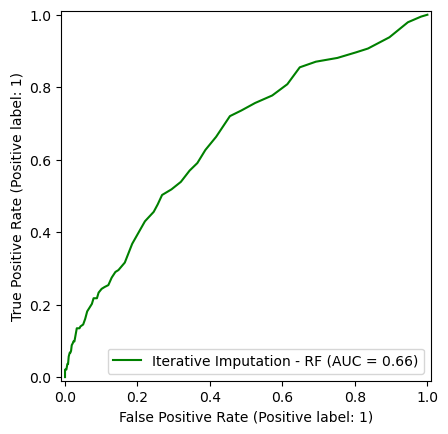

In [70]:
evaluate_models(df_mean, "Mean Imputation")
evaluate_models(df_median, "Median Imputation")
evaluate_models(df_knn, "KNN Imputation")
evaluate_models(df_iter, "Iterative Imputation")

In [71]:
summary_df = pd.DataFrame(results)
summary_df_sorted = summary_df.sort_values(by=["Imputation Method", "Model"]).reset_index(drop=True)
display(summary_df_sorted)

,Imputation Method,Model,Accuracy,ROC AUC
0,Iterative Imputation,Logistic Regression,0.845912,0.701268
1,Iterative Imputation,Random Forest,0.847484,0.658883
2,KNN Imputation,Logistic Regression,0.845912,0.703127
3,KNN Imputation,Random Forest,0.845126,0.661479
4,Mean Imputation,Logistic Regression,0.845126,0.701888
5,Mean Imputation,Random Forest,0.845126,0.668622
6,Median Imputation,Logistic Regression,0.845126,0.701652
7,Median Imputation,Random Forest,0.844340,0.643673


### Plotting for Comparison

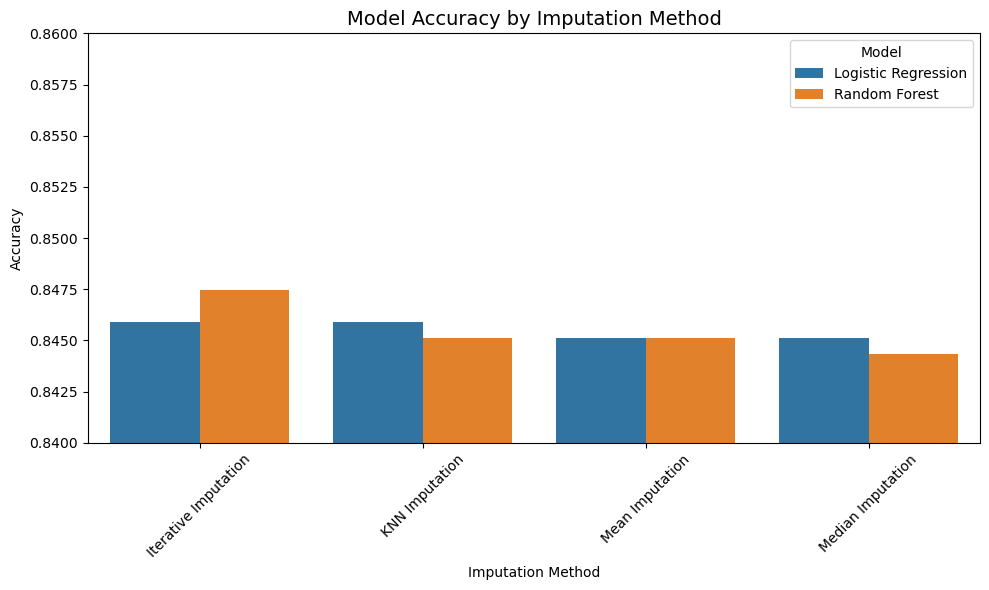

In [77]:
#Grouped Bar Plot – Accuracy

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df_sorted, x="Imputation Method", y="Accuracy", hue="Model")
plt.title("Model Accuracy by Imputation Method", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0.84, 0.86)
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

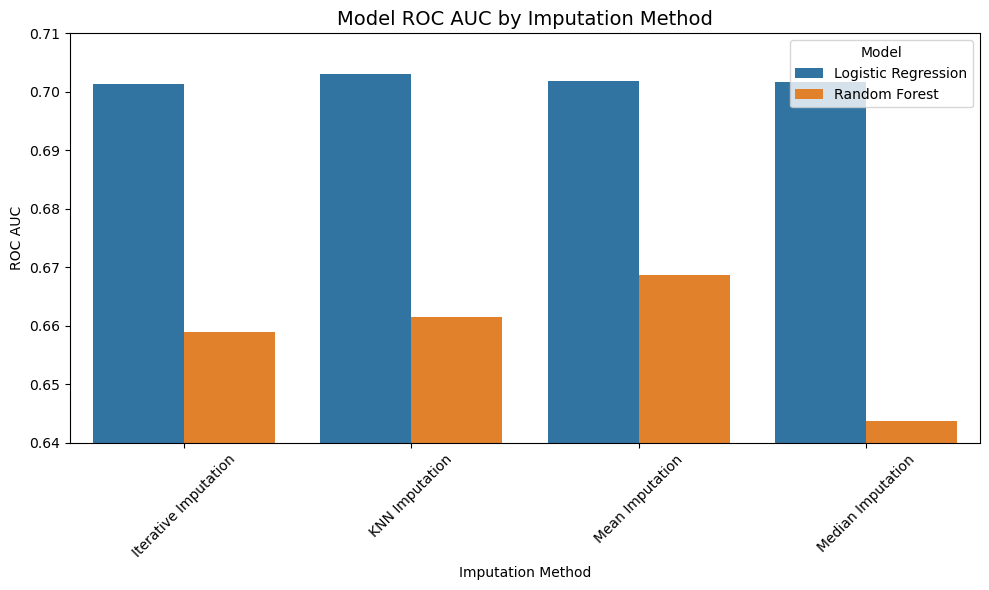

In [78]:
#Grouped Bar Plot – ROC AUC
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df_sorted, x="Imputation Method", y="ROC AUC", hue="Model")
plt.title("Model ROC AUC by Imputation Method", fontsize=14)
plt.ylabel("ROC AUC")
plt.ylim(0.64, 0.71)
plt.xticks(rotation=45)
plt.legend(title="Model")
plt.tight_layout()
plt.show()